In [ ]:
"""Phase 1: Data Collection and Exploratory Data Analysis (EDA)
Step 1 - Data Import and Preprocessing
Dataset 
 Load the dataset (Food_Delivery_Time_Prediction.csv).
Handle Missing Values
 Check for any missing or inconsistent values in columns such as Distance, Delivery_Time, etc. and decide how to handle them, either through imputation or deletion."""

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the dataset
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')

# display the first few rows of the dataset
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [ ]:
# tep 2: Clean and Transform the Data
# handle missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64


In [ ]:
# Convert Customer_Location and Restaurant_Location to Lat/Lon
# Extract lat/lon from tuples
df[['Customer_Lat', 'Customer_Lon']] = df['Customer_Location'].apply(lambda x: pd.Series(eval(x)))
df[['Restaurant_Lat', 'Restaurant_Lon']] = df['Restaurant_Location'].apply(lambda x: pd.Series(eval(x)))

In [ ]:
# Handle missing values
#drop rows with missing dilivary time or critical features
df.dropna(subset=['Delivery_Time', 'Distance', 'Customer_Lat', 'Customer_Lon', 'Restaurant_Lat', 'Restaurant_Lon'], inplace=True)

#fill other missing numericals columns (if any)
df.fillna(df.median(numeric_only=True), inplace=True)
# df.fillna({
#     'Distance': df['Distance'].mean(),
#     'Delivery_Time': df['Delivery_Time'].mean(),
#     'Customer_Lat': df['Customer_Lat'].mean(),
#     'Customer_Lon': df['Customer_Lon'].mean(),
#     'Restaurant_Lat': df['Restaurant_Lat'].mean(),
#     'Restaurant_Lon': df['Restaurant_Lon'].mean()
# }, inplace=True)

In [ ]:
# Clean column names again just in case
df.columns = df.columns.str.strip()

# Try to one-hot encode the expected columns safely
categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']

# Check which ones are actually present
available = [col for col in categorical_cols if col in df.columns]
missing = [col for col in categorical_cols if col not in df.columns]

if missing:
    print("Missing columns:", missing)

# Proceed with the columns that are present
df = pd.get_dummies(df, columns=available, drop_first=True)


Missing columns: ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']


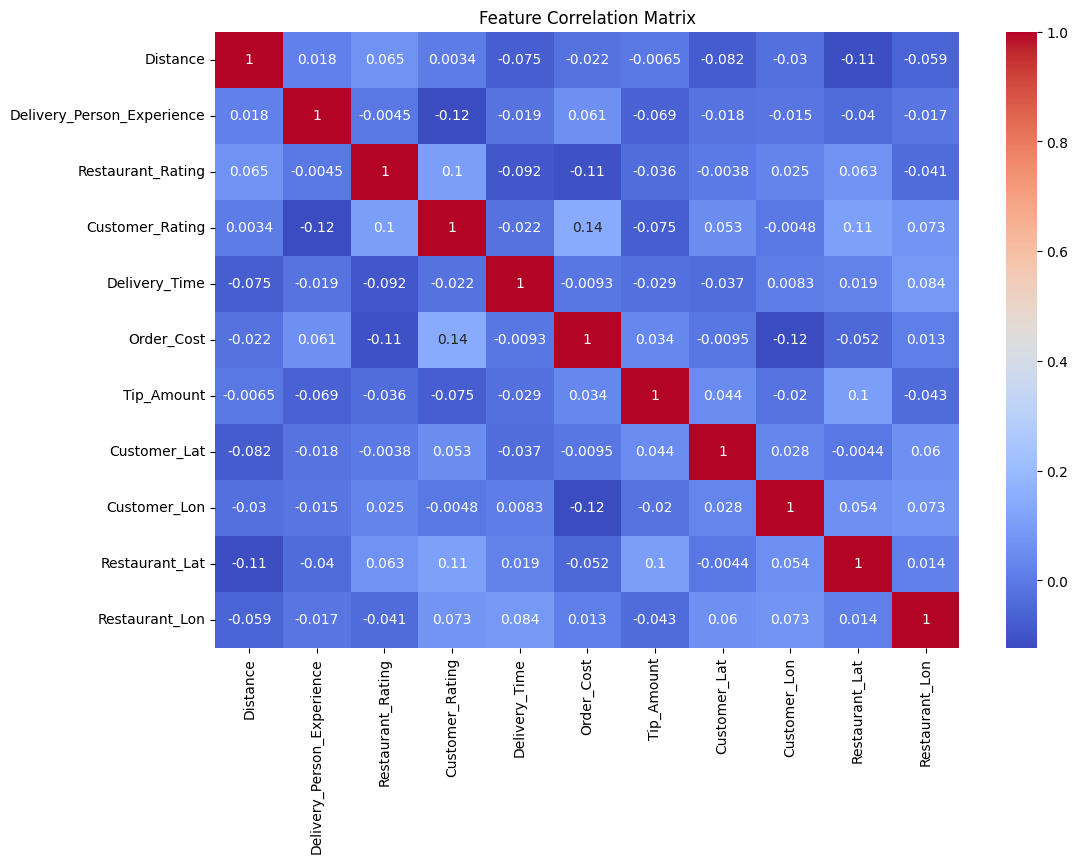

In [ ]:
# Select numeric columns only
numeric_df = df.select_dtypes(include=['number'])

# Plot correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
from geopy.distance import geodesic
# Calculate the distance between customer and restaurant locations
def calculate_distance(row):
    customer_location = (row['Customer_Lat'], row['Customer_Lon'])
    restaurant_location = (row['Restaurant_Lat'], row['Restaurant_Lon'])
    return geodesic(customer_location, restaurant_location).kilometers
df['Calculated_Distance'] = df.apply(calculate_distance, axis=1)


In [ ]:
# Set Rush Hour if order time was Afternoon or Night
df['Rush_Hour'] = df.get('Order_Time_Afternoon', 0) | df.get('Order_Time_Night', 0)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare features and target
X = df.drop(columns=['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Delivery_Time'])
y = df['Delivery_Time']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions and evaluation
y_pred = lr.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 957.7974224187868
MAE: 26.533801030950663
R²: -0.035578468738285185


In [ ]:
# Create binary label
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 1 if x <= 30 else 0)

# Prepare features and target
X_clf = df.drop(columns=['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Delivery_Time', 'Delivery_Status'])
y_clf = df['Delivery_Status']

# Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_clf, y_train_clf)
y_pred_clf = clf.predict(X_test_clf)


C:\Users\tanis\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.85      1.00      0.92        34
           1       0.00      0.00      0.00         6

    accuracy                           0.85        40
   macro avg       0.42      0.50      0.46        40
weighted avg       0.72      0.85      0.78        40



C:\Users\tanis\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tanis\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tanis\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

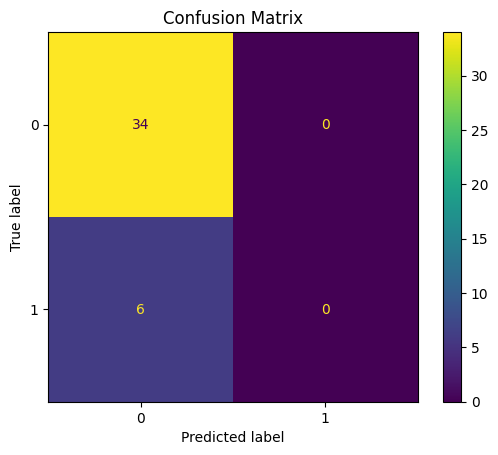

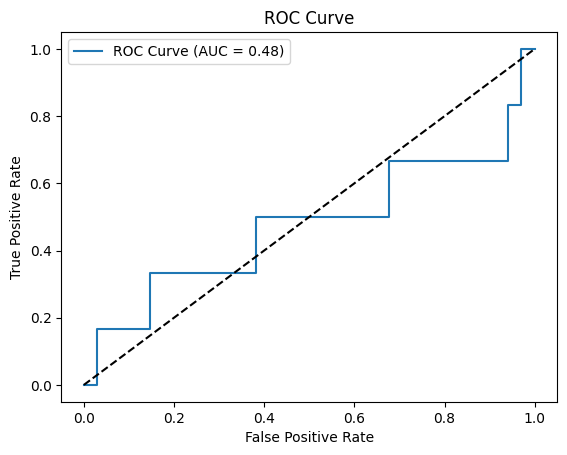

In [ ]:
# Classification report
print(classification_report(y_test_clf, y_pred_clf))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(clf, X_test_clf, y_test_clf)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_clf, clf.predict_proba(X_test_clf)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
'''1. Jupyter Notebook (.ipynb)
Contains all preprocessing, modeling, and visualizations.

2. Visuals
Correlation matrix

Boxplots

Confusion matrix

ROC curve

3. Final Report
Dataset description

Feature analysis

Model comparisons

Business recommendations'''